In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [3]:
# Lee el archivo Excel
datos = pd.read_excel("housepricedata.xlsx")

# Muestra las primeras filas del DataFrame
datos.head()

,LotArea,OverallQual,OverallCond,TotalBsmtSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,AboveMedianPrice
0,8450,7,5,856,2,1,3,8,0,548,1
1,9600,6,8,1262,2,0,3,6,1,460,1
2,11250,7,5,920,2,1,3,6,1,608,1
3,9550,7,5,756,1,0,3,7,1,642,0
4,14260,8,5,1145,2,1,4,9,1,836,1


In [4]:
# Separamos la ultima columna para que sea variable destino
datos_y = datos[datos.columns[-1]]
datos_y.head()

0    1
1    1
2    1
3    0
4    1
Name: AboveMedianPrice, dtype: int64

In [5]:
#eliminamos la tabla de la variable de destino
datos_x = datos.drop(columns=["AboveMedianPrice"])
datos_x.head()

,LotArea,OverallQual,OverallCond,TotalBsmtSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea
0,8450,7,5,856,2,1,3,8,0,548
1,9600,6,8,1262,2,0,3,6,1,460
2,11250,7,5,920,2,1,3,6,1,608
3,9550,7,5,756,1,0,3,7,1,642
4,14260,8,5,1145,2,1,4,9,1,836


In [6]:
#Ahora vamos a escalar los valores para que esten dentro de un rango mas corto.
escalador = StandardScaler()
datos_x = escalador.fit_transform(datos_x)
print(datos_x)

[[-0.20714171  0.65147924 -0.51719981 ...  0.91220977 -0.95122649
   0.35100032]
 [-0.09188637 -0.07183611  2.17962776 ... -0.31868327  0.60049493
  -0.06073101]
 [ 0.07347998  0.65147924 -0.51719981 ... -0.31868327  0.60049493
   0.63172623]
 ...
 [-0.14781027  0.65147924  3.07857028 ...  1.52765629  2.15221636
  -1.03391416]
 [-0.08016039 -0.79515147  0.38174271 ... -0.93412978 -0.95122649
  -1.09005935]
 [-0.05811155 -0.79515147  0.38174271 ... -0.31868327 -0.95122649
  -0.9216238 ]]


In [7]:
#imprimimos la cantidad de datos que tenemos
datos_x.shape[0]

1460

In [8]:
from sklearn.model_selection import train_test_split

# Esta función divide los datos en conjuntos de entrenamiento y prueba
# datos_x: son las características (features) de entrada
# datos_y: son las etiquetas (labels) de salida
# test_size: define el tamaño del conjunto de prueba. En este caso, 20% de los datos se usarán para prueba y 80% para entrenamiento
# random_state: se usa para asegurar que la división sea reproducible. El número 2 es una semilla fija para el generador de números aleatorios

X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size=0.2, random_state=2)

# X_train: conjunto de entrenamiento para las características de entrada
# X_test: conjunto de prueba para las características de entrada
# y_train: conjunto de entrenamiento para las etiquetas de salida
# y_test: conjunto de prueba para las etiquetas de salida


In [9]:
print("X Train: {}, X Test: {}, y_train: {}, y_test: {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X Train: (1168, 10), X Test: (292, 10), y_train: (1168,), y_test: (292,)


In [28]:
n_entradas = X_train.shape[1]
print(n_entradas)

10


In [11]:
# Convierte el conjunto de características de entrenamiento (X_train) a un tensor de PyTorch, 
# cambia su tipo de datos a float y lo mueve al dispositivo CPU
t_X_train = torch.from_numpy(X_train).float().to("cpu")  # MPS se refiere a Metal Performance Shaders, usado en dispositivos Apple

# Convierte el conjunto de características de prueba (X_test) a un tensor de PyTorch,
# cambia su tipo de datos a float y lo mueve al dispositivo CPU
t_X_test = torch.from_numpy(X_test).float().to("cpu")

# Convierte las etiquetas de entrenamiento (y_train) a un tensor de PyTorch,
# cambia su tipo de datos a float y lo mueve al dispositivo CPU
t_y_train = torch.from_numpy(y_train.values).float().to("cpu")

# Convierte las etiquetas de prueba (y_test) a un tensor de PyTorch,
# cambia su tipo de datos a float y lo mueve al dispositivo CPU
t_y_test = torch.from_numpy(y_test.values).float().to("cpu")

# Añade una nueva dimensión a las etiquetas de entrenamiento para que sean compatibles con las operaciones de PyTorch.
# Esto convierte t_y_train de forma (N,) a (N,1), donde N es el número de muestras
t_y_train = t_y_train[:, None]

# Añade una nueva dimensión a las etiquetas de prueba para que sean compatibles con las operaciones de PyTorch.
# Esto convierte t_y_test de forma (N,) a (N,1), donde N es el número de muestras
t_y_test = t_y_test[:, None]


In [12]:
test = TensorDataset(t_X_test, t_y_test)
print(test[0])

(tensor([ 0.5096,  0.6515,  2.1796,  1.0114,  0.7897, -0.7616, -2.2887, -0.3187,
         2.1522,  0.0516]), tensor([1.]))


In [13]:
t_y_train

tensor([[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [1.],
        [0.]])

In [29]:
class Red(nn.Module):
    
    def __init__(self, n_entradas):
        super(Red, self).__init__()
        self.linear1 = nn.Linear(n_entradas, 15)
        self.linear2 = nn.Linear(15, 30)
        self.linear3 = nn.Linear(30,50)
        self.linear4 = nn.Linear(50, 20)
        self.linear5 = nn.Linear(20, 8)
        self.linear6 = nn.Linear(8, 1)
    
    def forward(self, inputs):
        pred_1 = torch.sigmoid(input=self.linear1(inputs))
        pred_2 = torch.sigmoid(input=self.linear2(pred_1))
        pred_3 = torch.sigmoid(input=self.linear3(pred_2))
        pred_4 = torch.sigmoid(input=self.linear4(pred_3))
        pred_5 = torch.sigmoid(input=self.linear5(pred_4))
        pred_f = torch.sigmoid(input=self.linear6(pred_5))
        return pred_f

In [30]:
t_y_test[0]

tensor([1.])

In [39]:
%%time
lr = 0.001
epochs = 2000
estatus_print = 100

model = Red(n_entradas=n_entradas)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
print("Arquitectura del modelo: {}".format(model))
historico = pd.DataFrame()

print("Entrenamos el modelo")
for epoch in range(1, epochs+1):
    y_pred= model(t_X_train)
    loss = loss_fn(input=y_pred, target=t_y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoch} \t Loss: {round(loss.item(), 4)}")
    
    with torch.no_grad():
        y_pred = model(t_X_test)
        y_pred_class = y_pred.round()
        correct = (y_pred_class == t_y_test).sum()
        accuracy = 100 * correct / float(len(t_y_test))
        if epoch % estatus_print == 0:
            print("Accuracy: {}".format(accuracy.item()))
    
    df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss': round(loss.item(), 4),
        'Accuracy': round(accuracy.item(), 4)
    }, index=[0])
    historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)

print("Accuracy final: {}".format(round(accuracy.item(), 4)))

Arquitectura del modelo: Red(
  (linear1): Linear(in_features=10, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=30, bias=True)
  (linear3): Linear(in_features=30, out_features=50, bias=True)
  (linear4): Linear(in_features=50, out_features=20, bias=True)
  (linear5): Linear(in_features=20, out_features=8, bias=True)
  (linear6): Linear(in_features=8, out_features=1, bias=True)
)
Entrenamos el modelo

Epoch 100 	 Loss: 0.6922
Accuracy: 46.917808532714844

Epoch 200 	 Loss: 0.6362
Accuracy: 85.95890045166016

Epoch 300 	 Loss: 0.3594
Accuracy: 88.01370239257812

Epoch 400 	 Loss: 0.3005
Accuracy: 88.01370239257812

Epoch 500 	 Loss: 0.2675
Accuracy: 88.01370239257812

Epoch 600 	 Loss: 0.2495
Accuracy: 87.67123413085938

Epoch 700 	 Loss: 0.2363
Accuracy: 87.67123413085938

Epoch 800 	 Loss: 0.2238
Accuracy: 88.6986312866211

Epoch 900 	 Loss: 0.2029
Accuracy: 89.72602844238281

Epoch 1000 	 Loss: 0.1805
Accuracy: 89.72602844238281

Epoch 1100 	 Loss: 0.165

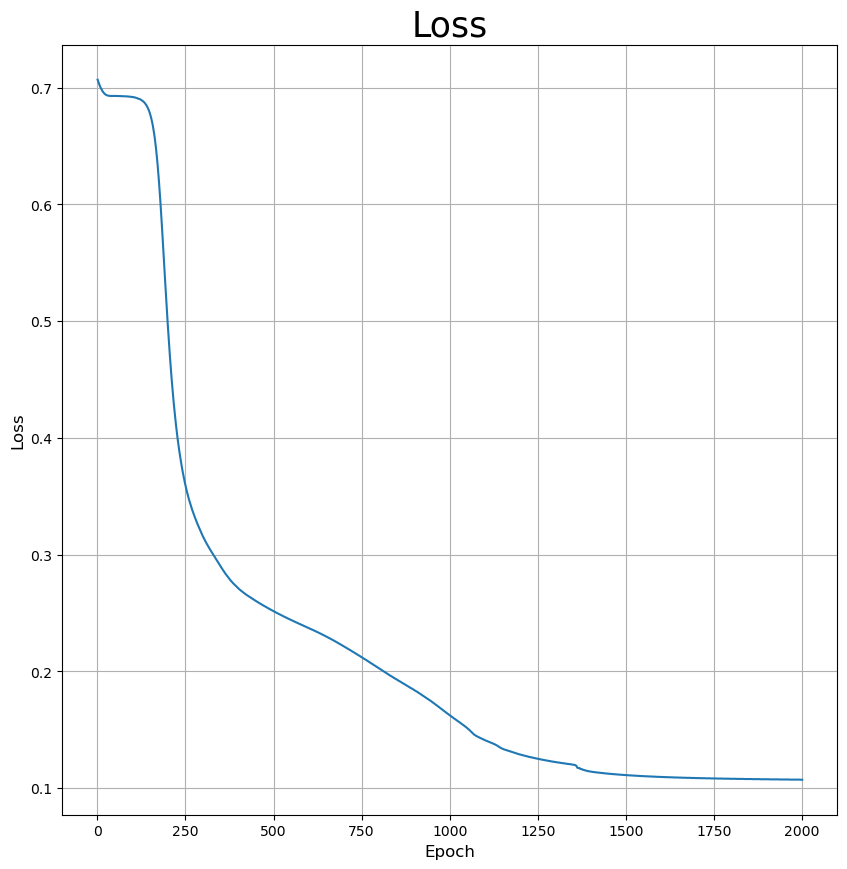

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Loss'], label='Loss')
plt.title("Loss", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid()
plt.show()

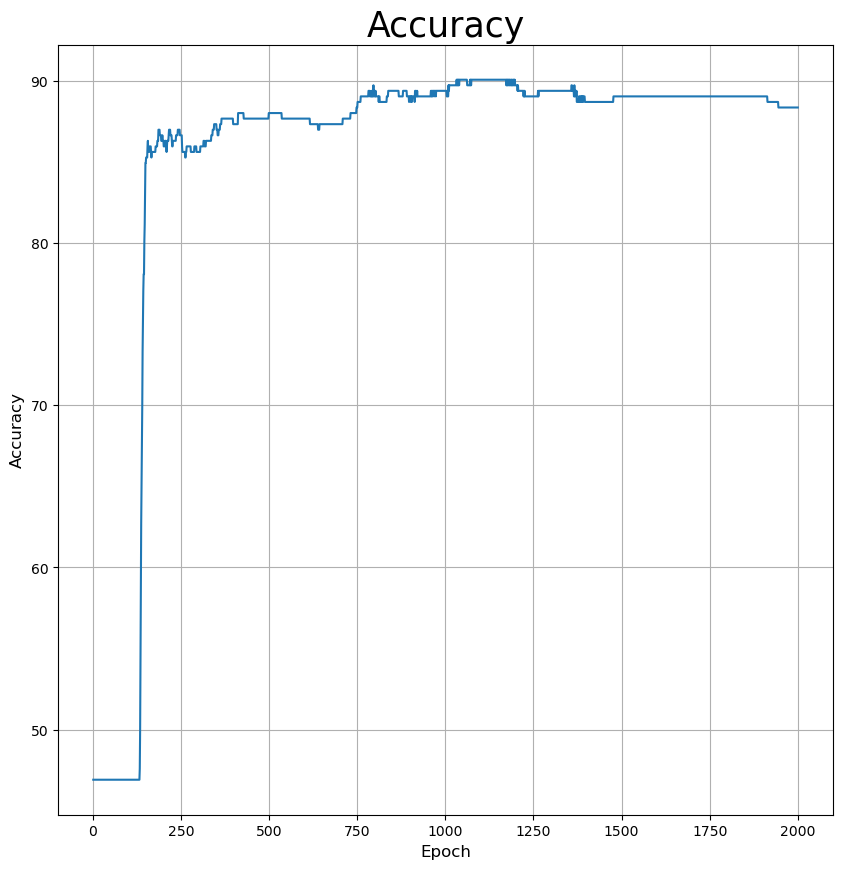

In [33]:
plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Accuracy'], label='Accuracy')
plt.title("Accuracy", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.show()

In [34]:
t_X_test[5]

tensor([ 0.6267,  0.6515, -0.5172,  0.3137,  0.7897,  1.2276,  1.3900,  0.2968,
        -0.9512,  0.0609])

In [35]:
prediccion = model(t_X_test[4])
print(prediccion)

tensor([0.9746], grad_fn=<SigmoidBackward0>)


In [36]:
t_y_test[4]

tensor([1.])